In [1]:
# Imports
import win32com.client
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB 
from sklearn import model_selection
# from sklearn import cross_validation
pd.set_option('display.max_rows', 1000)

In [2]:
# Variables that can be changed based on user settings
excelPath = "C:/Queen's/CISC 499/Data/CarotidData-Ver3.xlsx"
dataPath = "C:/Queen's/CISC 499/Data/MASK-train_val_test_split.xlsx"
num_classes = 2 # Number of different labels

In [3]:
# Load carotid data based on Ricky's advice
carotid_data = pd.read_excel(excelPath, skipfooter=18, usecols="A,B,D,G,H,I,N,O,P,Q,R,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AY,AZ,BA,BB,BC,BD,BE,BF,BG,BH,BI,BJ,BK,BL,BM,BN,BO")
carotid_label = pd.read_excel(excelPath, skipfooter=18, usecols="A,BU")

# Convert binary values F/M or YES/NO to 1/0
mapping = {'M': 0, 'NO': 0, 'N': 0, 'F': 1, 'YES': 1, 'Y': 1, 'UNKNOWN': 2}
carotid_data = carotid_data.applymap(lambda s: mapping.get(s) if s in mapping else s)

# Generate p-value table
import statsmodels.api as sm
# If p-value < 0.05 -->Significant
# If p-value > 0.05 -->Not Significant

labels = carotid_label['Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor']
features = carotid_data.drop('Study ID #', axis=1)

X_train,X_test, Y_train, Y_test = model_selection.train_test_split(features, labels, test_size = .2, random_state = 10)
x_incl_cons = sm.add_constant(X_train)
model = sm.OLS(Y_train, x_incl_cons)  #ordinary least square
results = model.fit()  #regresssion results
# results.params
# results.pvalues
pd.DataFrame({'coef': results.params , 'pvalue': round(results.pvalues,3)})

C:\Users\fokxd\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,coef,pvalue
const,-645.991729,0.472
Age (yrs) at time of study,0.005593,0.040
Sex,-0.050384,0.308
Creatinine (µmol/L),0.001322,0.031
eGFR (mL/min/1.73 m2),0.001741,0.205
BMI (kg/m2),0.000157,0.967
Diabetes (Y/N),0.040584,0.438
Tobacco use (Y/N),0.053676,0.375
History of Hypertension (Y/N),-0.019164,0.724
Hyperlipidemia (Y/N),0.059455,0.303


In [4]:
# Perform tukey HSD test to compare statistical significance between each pair of features
from bioinfokit.analys import stat
df_melt = pd.melt(features.reset_index(), id_vars=['index'], value_vars=['Age (yrs) at time of study', 'Sex',
                                                                        'Creatinine (µmol/L)', 'eGFR (mL/min/1.73 m2)',
                                                                        'BMI (kg/m2)', 'Diabetes (Y/N)', 'Tobacco use (Y/N)',
                                                                        'History of Hypertension (Y/N)', 'Hyperlipidemia (Y/N)',
                                                                        'Family history of Cardiac Disease (Y/N)',
                                                                        'Rt CCA Distal far wall mean IMT (mm)',
                                                                        'Lt CCA Distal far wall mean IMT (mm)',
                                                                        'Mean CIMT, CCA far distal (mm)',
                                                                        'Rt Max Plaque Height (mm)','Lt Max Plaque Height (mm)',
                                                                        'Max Plaque Height (PH), Rt or Lt Bulbs (mm)',
                                                                        'Max PH ≥1.5 mm', 'Rt Area (mm2)', 'Lt Area (mm2)',
                                                                        'Total Plaque Area (TPA), Rt + Lt Bulbs (mm2)',
                                                                        'Left GSM (all sections)', 'LT % blood (0-4)',
                                                                        'LT % fat (8-26)', 'LT % muscle (41-76)', 
                                                                        'LT % fibrous tissue (112-196)', 'LT % calcium (211-255)',
                                                                        'LT % undefined', 'LT p40', 'Mean GSM (Rt & Lt)',
                                                                        'adjusted mean % blood (0-4)', 'adjusted fat (8-26)',
                                                                        'adjusted mean % muscle (41-76)', 
                                                                        'adjusted mean % fibrous tissue (112-196)',
                                                                        'adjusted mean % calcium (211-255)',
                                                                        'adjusted mean % undefined', 'adjusted mean p40',
                                                                        'Mean Pixels <P40 (Rt & Lt)'])

df_melt.columns = ['index', 'features', 'value']

from bioinfokit.analys import stat
res = stat()

res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(features)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(features),36.0,1.078220e+07,299505.470877,1537.488771,0.0
Residual,19277.0,3.755193e+06,194.801729,NaN,NaN


In [5]:
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='features', anova_model='value ~ C(features)')
res.tukey_summary

C:\Users\fokxd\anaconda3\lib\site-packages\bioinfokit\analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Age (yrs) at time of study,Sex,64.825670,61.498763,68.152578,106.117220,0.001000
1,Age (yrs) at time of study,Creatinine (µmol/L),25.235632,21.908724,28.562540,41.309795,0.001000
2,Age (yrs) at time of study,eGFR (mL/min/1.73 m2),9.598465,6.271557,12.925373,15.712332,0.001000
3,Age (yrs) at time of study,BMI (kg/m2),35.359078,32.032170,38.685986,57.881500,0.001000
4,Age (yrs) at time of study,Diabetes (Y/N),64.871648,61.544740,68.198555,106.192483,0.001000
5,Age (yrs) at time of study,Tobacco use (Y/N),64.986590,61.659682,68.313498,106.380640,0.001000
6,Age (yrs) at time of study,History of Hypertension (Y/N),64.434866,61.107958,67.761774,105.477488,0.001000
7,Age (yrs) at time of study,Hyperlipidemia (Y/N),64.360153,61.033245,67.687061,105.355186,0.001000
8,Age (yrs) at time of study,Family history of Cardiac Disease (Y/N),64.379310,61.052403,67.706218,105.386545,0.001000
9,Age (yrs) at time of study,Rt CCA Distal far wall mean IMT (mm),64.325153,60.998245,67.652061,105.297892,0.001000


In [6]:
# Collinearity filter to account for plaque columns being similar
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix) for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True
            
    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

carotid_data = calculate_vif_(carotid_data)
# print(carotid_data)

C:\Users\fokxd\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping 'Rt CCA Distal far wall mean IMT (mm)' at index: 11
dropping 'Mean Pixels <P40 (Rt & Lt)' at index: 36
dropping 'LT % muscle (41-76)' at index: 23
dropping 'adjusted mean p40' at index: 34
dropping 'Total Plaque Area (TPA), Rt + Lt Bulbs (mm2)' at index: 19
dropping 'Mean GSM (Rt & Lt)' at index: 26
dropping 'adjusted mean % undefined' at index: 31
dropping 'LT p40' at index: 25
dropping 'Left GSM (all sections)' at index: 19
dropping 'Mean CIMT, CCA far distal (mm)' at index: 12
dropping 'LT % undefined' at index: 22
dropping 'Age (yrs) at time of study' at index: 1
dropping 'Max Plaque Height (PH), Rt or Lt Bulbs (mm)' at index: 13
dropping 'BMI (kg/m2)' at index: 4
dropping 'adjusted fat (8-26)' at index: 20
dropping 'eGFR (mL/min/1.73 m2)' at index: 3
dropping 'Lt CCA Distal far wall mean IMT (mm)' at index: 8
dropping 'adjusted mean % fibrous tissue (112-196)' at index: 19
dropping 'Max PH ≥1.5 mm' at index: 10
Remaining variables:
Index(['Study ID #', 'Sex', 'Creatinine 

In [7]:
# Load training data and labels
train_id = pd.read_excel(dataPath, sheet_name=0, usecols="A")
train_label = []
train_data = []
train_id = train_id.to_numpy()
# Match the id's to the correct data rows
for study_id in train_id:
    data = carotid_data.loc[carotid_data['Study ID #'] == int(study_id)]
    train_data.append(data.values.tolist()[0][1:]) # Only takes the data columns i.e. not the study ID
    label = carotid_label.loc[carotid_label['Study ID #'] == int(study_id)]
    train_label.append(label.values.tolist()[0][1]) # Only takes the label column
            
# print(train_data)
# print(train_label)

# Load validation data and labels
validation_id = pd.read_excel(dataPath, sheet_name=1, usecols="A")
validation_label = []
validation_data = []
validation_id = validation_id.to_numpy()
# Match the id's to the correct data rows
for study_id in validation_id:
    data = carotid_data.loc[carotid_data['Study ID #'] == int(study_id)]
    validation_data.append(data.values.tolist()[0][1:]) # Only takes the data columns i.e. not the study ID
    label = carotid_label.loc[carotid_label['Study ID #'] == int(study_id)]
    validation_label.append(label.values.tolist()[0][1]) # Only takes the label column
            
# print(validation_data)
# print(validation_label)

# Load test data and labels
test_id = pd.read_excel(dataPath, sheet_name=2, usecols="A")
test_label = []
test_data = []
test_id = test_id.to_numpy()
# Match the id's to the correct data rows
for study_id in test_id:
    data = carotid_data.loc[carotid_data['Study ID #'] == int(study_id)]
    test_data.append(data.values.tolist()[0][1:]) # Only takes the data columns i.e. not the study ID
    label = carotid_label.loc[carotid_label['Study ID #'] == int(study_id)]
    test_label.append(label.values.tolist()[0][1]) # Only takes the label column
            
# print(test_data)
# print(test_label)

In [8]:
# Create Naive Bayes classifier 
classifier = GaussianNB()

# Train the classifier
classifier.fit(train_data, train_label)

# Predict the values for training data
y_pred = classifier.predict(train_data)

# Compute accuracy
accuracy = 100.0 * (train_label == y_pred).sum() / len(train_label)
print("Training Accuracy of Naive Bayes classifier =", round(accuracy, 2), "%")

# Predict the values for test data
y_pred = classifier.predict(test_data)

# Compute accuracy
accuracy = 100.0 * (test_label == y_pred).sum() / len(test_label)
print("Test Accuracy of Naive Bayes classifier =", round(accuracy, 2), "%")

Training Accuracy of Naive Bayes classifier = 65.0 %
Test Accuracy of Naive Bayes classifier = 65.52 %


Recall/Sensitivity/True positive rate:  0.46153846153846156
Specificity/selectivity/True negative rate:  0.8125
Precision/Positive predictive value:  0.6666666666666666
Negative predictive value:  0.65
F1 score:  0.5454545454545455


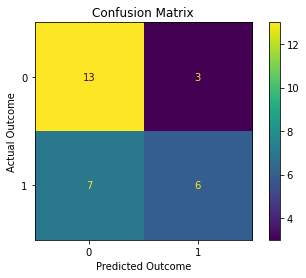

AUC value:  0.6370192307692307


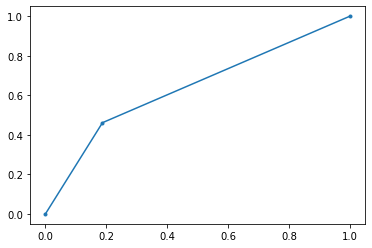

In [10]:
# GENERATE METRICS
cm = confusion_matrix(test_label, y_pred)
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)
f1 = 2 * ((ppv * tpr) / (ppv + tpr))

print("Recall/Sensitivity/True positive rate: ", tpr)
print("Specificity/selectivity/True negative rate: ", tnr)
print("Precision/Positive predictive value: ", ppv)
print("Negative predictive value: ", npv)
print("F1 score: ", f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(np.unique(train_label)))
disp.plot()
disp.ax_.set(
                title='Confusion Matrix', 
                xlabel='Predicted Outcome', 
                ylabel='Actual Outcome')
plt.show()

# test roc
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(test_label, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
print("AUC value: ", auc_keras)

In [11]:
# Create SVM classifier
from sklearn import svm
clf = svm.SVC(C=1,kernel="linear")

# Train the classifier
clf.fit(train_data, train_label)

# Predict the values for training data
y_pred = clf.predict(train_data)

# Compute accuracy
accuracy = 100.0 * (train_label == y_pred).sum() / len(train_label)
print("Training Accuracy of SVM classifier =", round(accuracy, 2), "%")

# Predict the values for test data
y_pred = clf.predict(test_data)

# Compute accuracy
accuracy = 100.0 * (test_label == y_pred).sum() / len(test_label)
print("Test Accuracy of SVM classifier =", round(accuracy, 2), "%")

Training Accuracy of SVM classifier = 71.36 %
Test Accuracy of SVM classifier = 48.28 %


Recall/Sensitivity/True positive rate:  0.07692307692307693
Specificity/selectivity/True negative rate:  0.8125
Precision/Positive predictive value:  0.25
Negative predictive value:  0.52
F1 score:  0.11764705882352941


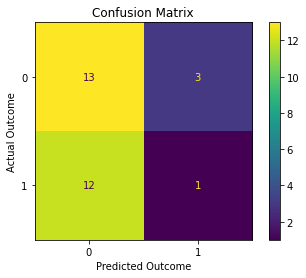

AUC value:  0.44471153846153844


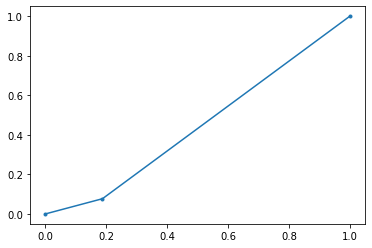

In [12]:
# GENERATE METRICS
cm = confusion_matrix(test_label, y_pred)
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)
f1 = 2 * ((ppv * tpr) / (ppv + tpr))

print("Recall/Sensitivity/True positive rate: ", tpr)
print("Specificity/selectivity/True negative rate: ", tnr)
print("Precision/Positive predictive value: ", ppv)
print("Negative predictive value: ", npv)
print("F1 score: ", f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(np.unique(train_label)))
disp.plot()
disp.ax_.set(
                title='Confusion Matrix', 
                xlabel='Predicted Outcome', 
                ylabel='Actual Outcome')
plt.show()

# test roc
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(test_label, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
print("AUC value: ", auc_keras)

In [10]:
# Process the data into a readable format for the MLP
train_data = np.asarray(train_data).astype('float32')
train_label = np.reshape(train_label, -1)
train_label = to_categorical(train_label, num_classes)

validation_data = np.asarray(validation_data).astype('float32')
validation_label = np.reshape(validation_label, -1)
validation_label = to_categorical(validation_label, num_classes)

test_data = np.asarray(test_data).astype('float32')
test_label = np.reshape(test_label, -1)
test_label = to_categorical(test_label, num_classes)

# print(train_data)
# print(validation_data)
# print(test_data)

print(len(train_label))
print(len(validation_label))
print(len(test_label))

# print(len(train_data), len(validation_data))

220
45
29


In [11]:
# Create the model
model = Sequential()
model.add(Dense(40, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [12]:
# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_data, train_label, batch_size=32, epochs=50, verbose=1, validation_data=(validation_data, validation_label))

Epoch 1/50
7/7 [==============================] - 0s 20ms/step - loss: 18.9622 - accuracy: 0.3955 - val_loss: 9.9634 - val_accuracy: 0.4889
Epoch 2/50
7/7 [==============================] - 0s 4ms/step - loss: 7.8819 - accuracy: 0.5000 - val_loss: 4.4284 - val_accuracy: 0.5556
Epoch 3/50
7/7 [==============================] - 0s 3ms/step - loss: 3.4735 - accuracy: 0.5727 - val_loss: 5.6258 - val_accuracy: 0.5333
Epoch 4/50
7/7 [==============================] - 0s 4ms/step - loss: 4.0863 - accuracy: 0.6318 - val_loss: 6.2104 - val_accuracy: 0.5111
Epoch 5/50
7/7 [==============================] - 0s 4ms/step - loss: 3.6346 - accuracy: 0.6227 - val_loss: 4.5813 - val_accuracy: 0.5778
Epoch 6/50
7/7 [==============================] - 0s 3ms/step - loss: 2.6580 - accuracy: 0.6364 - val_loss: 3.8366 - val_accuracy: 0.5778
Epoch 7/50
7/7 [==============================] - 0s 3ms/step - loss: 2.6260 - accuracy: 0.6455 - val_loss: 3.5027 - val_accuracy: 0.5556
Epoch 8/50
7/7 [================

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                760       
                                                                 
 dense_1 (Dense)             (None, 10)                410       
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 1,192
Trainable params: 1,192
Non-trainable params: 0
_________________________________________________________________


In [14]:
# EVALUATE THE MODEL
loss, acc = model.evaluate(test_data, test_label, verbose=2)
print("Model, accuracy: {:5.2f}%".format(100 * acc))

1/1 - 0s - loss: 0.8407 - accuracy: 0.6207 - 11ms/epoch - 11ms/step
Model, accuracy: 62.07%


In [15]:
# MAKE PREDICTIONS
predictions = np.argmax(model.predict(test_data), axis=1)

print("Predictions: ", predictions)
print("Ground truth: ", test_label)

Predictions:  [1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0]
Ground truth:  [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


Recall/Sensitivity/True positive rate:  0.46153846153846156
Specificity/selectivity/True negative rate:  0.75
Precision/Positive predictive value:  0.6
Negative predictive value:  0.631578947368421
F1 score:  0.5217391304347826


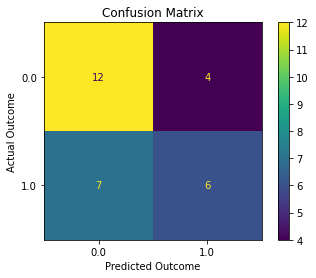

AUC value:  0.6057692307692308


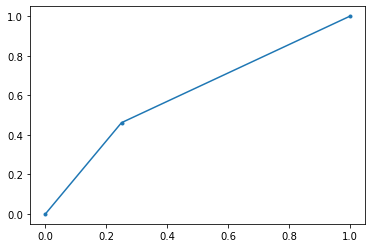

In [16]:
# GENERATE METRICS
cm = confusion_matrix(np.argmax(test_label, axis=1), predictions)
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)
f1 = 2 * ((ppv * tpr) / (ppv + tpr))

print("Recall/Sensitivity/True positive rate: ", tpr)
print("Specificity/selectivity/True negative rate: ", tnr)
print("Precision/Positive predictive value: ", ppv)
print("Negative predictive value: ", npv)
print("F1 score: ", f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(np.unique(train_label)))
disp.plot()
disp.ax_.set(
                title='Confusion Matrix', 
                xlabel='Predicted Outcome', 
                ylabel='Actual Outcome')
plt.show()

# test roc
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(np.argmax(test_label, axis=1), predictions)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
print("AUC value: ", auc_keras)

In [15]:
# Load carotid data based on Ricky's advice
data = pd.read_excel(excelPath, skipfooter=18, usecols="A,B,D,G,H,I,N,O,P,Q,R,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AY,AZ,BA,BB,BC,BD,BE,BF,BG,BH,BI,BJ,BK,BL,BM,BN,BO,BU")

# Convert binary values F/M or YES/NO to 1/0
mapping = {'M': 0, 'NO': 0, 'N': 0, 'F': 1, 'YES': 1, 'Y': 1, 'UNKNOWN': 2}
data = data.applymap(lambda s: mapping.get(s) if s in mapping else s)

data = calculate_vif_(data)

print(data)

C:\Users\fokxd\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping 'Rt CCA Distal far wall mean IMT (mm)' at index: 11
dropping 'Mean Pixels <P40 (Rt & Lt)' at index: 36
dropping 'LT % muscle (41-76)' at index: 23
dropping 'adjusted mean p40' at index: 34
dropping 'Total Plaque Area (TPA), Rt + Lt Bulbs (mm2)' at index: 19
dropping 'Mean GSM (Rt & Lt)' at index: 26
dropping 'adjusted mean % undefined' at index: 31
dropping 'LT p40' at index: 25
dropping 'Left GSM (all sections)' at index: 19
dropping 'Mean CIMT, CCA far distal (mm)' at index: 12
dropping 'LT % undefined' at index: 22
dropping 'Age (yrs) at time of study' at index: 1
dropping 'Max Plaque Height (PH), Rt or Lt Bulbs (mm)' at index: 13
dropping 'BMI (kg/m2)' at index: 4
dropping 'adjusted fat (8-26)' at index: 20
dropping 'eGFR (mL/min/1.73 m2)' at index: 3
dropping 'Lt CCA Distal far wall mean IMT (mm)' at index: 8
dropping 'adjusted mean % fibrous tissue (112-196)' at index: 19
dropping 'Max PH ≥1.5 mm' at index: 10
Remaining variables:
Index(['Study ID #', 'Sex', 'Creatinine 

In [16]:
# Create plots to visualize univariate data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<AxesSubplot:ylabel='Sex'>

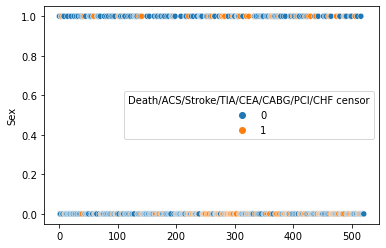

In [17]:
# Show multiple scatterplots to visualize univariate data
sns.scatterplot(x=data.index,y=data['Sex'],hue=data['Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor'])

<AxesSubplot:ylabel='Creatinine (µmol/L)'>

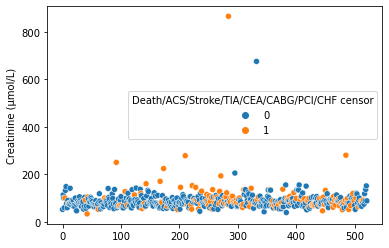

In [18]:
sns.scatterplot(x=data.index,y=data['Creatinine (µmol/L)'],hue=data['Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor'])

<AxesSubplot:ylabel='Diabetes (Y/N)'>

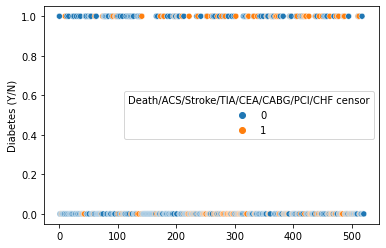

In [19]:
sns.scatterplot(x=data.index,y=data['Diabetes (Y/N)'],hue=data['Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor'])

<AxesSubplot:ylabel='Tobacco use (Y/N)'>

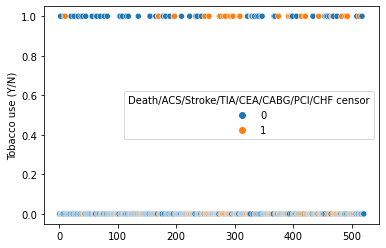

In [20]:
sns.scatterplot(x=data.index,y=data['Tobacco use (Y/N)'],hue=data['Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor'])

<AxesSubplot:ylabel='History of Hypertension (Y/N)'>

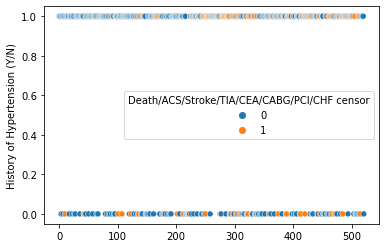

In [21]:
sns.scatterplot(x=data.index,y=data['History of Hypertension (Y/N)'],hue=data['Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor'])

<AxesSubplot:ylabel='Hyperlipidemia (Y/N)'>

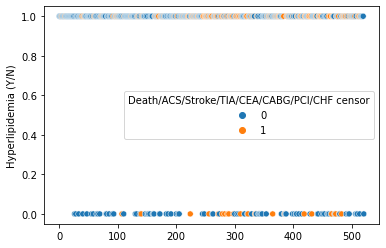

In [23]:
sns.scatterplot(x=data.index,y=data['Hyperlipidemia (Y/N)'],hue=data['Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor'])

{'whiskers': [<matplotlib.lines.Line2D at 0x12ad9dad820>,
 'caps': [<matplotlib.lines.Line2D at 0x12ad9dadf40>,
 'boxes': [<matplotlib.lines.Line2D at 0x12ad9dad490>],
 'medians': [<matplotlib.lines.Line2D at 0x12ad9db86a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x12ad9db8a30>],
 'means': []}

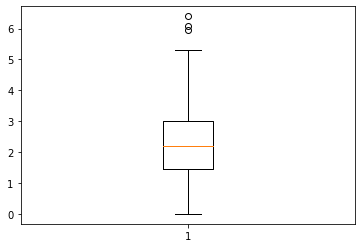

In [44]:
# Box plot of plaque height
plt.boxplot(data['Rt Max Plaque Height (mm)'])

{'whiskers': [<matplotlib.lines.Line2D at 0x12ad9d4c550>,
 'caps': [<matplotlib.lines.Line2D at 0x12ad9d4cc70>,
 'boxes': [<matplotlib.lines.Line2D at 0x12ad9d4c190>],
 'medians': [<matplotlib.lines.Line2D at 0x12ad9d573d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x12ad9d57760>],
 'means': []}

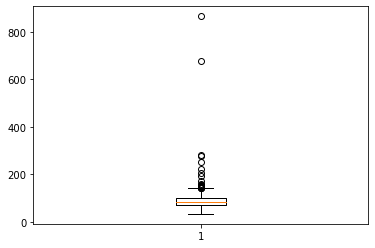

In [43]:
plt.boxplot(data['Creatinine (µmol/L)'])